# Synthetic Dataset

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data
Here the dataset has $x \sim U(-\pi, \pi)\times U(-1.5, 1.5)$. We then generate labels $y$ as $y = \left[\frac{1}{2}\sin(2x_0) < x_1\right]$. 

In [2]:
# 1000 x 2 ==> batch x features
x = th.rand([1000, 2])
x[:, 0] *= 2*pi
x[:, 0] -= pi
x[:, 1] *= 3
x[:, 1] -= 1.5

# Labels
y = (th.sin(x[:, 0] * 2) * 0.5 < x[:, 1]).long()

## Deep Forest

In [8]:
model = deep_forest.DeepForest(25, 2, 2, 1, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [9]:
%time model.train(2500, x, y)
print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(model.trees,x) == y).float())))

CPU times: user 937 ms, sys: 100 ms, total: 1.04 s
Wall time: 2min 55s

FINAL ACC: tensor(0.9820)


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


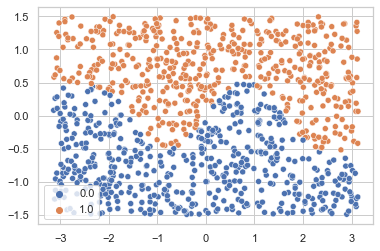

In [10]:
sns.scatterplot(x[:, 0], x[:, 1], hue=model.forward(model.trees, x, device).cpu().numpy())
plt.show()

In [18]:
imp = model.compute_importance(x)
print()
print(dict(imp))

100%|██████████| 32/32 [06:49<00:00, 12.80s/it]


{1: 0.7054406497598347, 0: 0.2945593502401654}


Text(0.5, 1.0, 'Synthetic Deep Forest Importance')

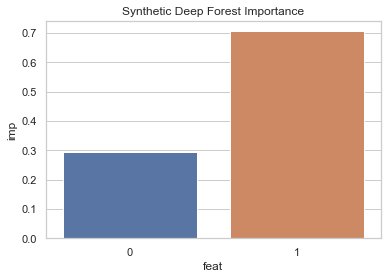

In [19]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data).set_title("Synthetic Deep Forest Importance")

## MLP Baseline

In [13]:
mlp = nn.Sequential(
    nn.Linear(2, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
for i in range(1000):
    optimizer.zero_grad()

    preds = mlp(x[:, :])
    loss = nn.functional.cross_entropy(preds, (y[:].type(th.LongTensor)).to(device))
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("====EPOCH %d====\nAcc: %s\nLoss: %s" % (i, str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())), str(loss)))

print("\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


====EPOCH 0====
Acc: tensor(0.4880)
Loss: tensor(0.6950, grad_fn=<NllLossBackward>)
====EPOCH 100====
Acc: tensor(0.8990)
Loss: tensor(0.4857, grad_fn=<NllLossBackward>)
====EPOCH 200====
Acc: tensor(0.9080)
Loss: tensor(0.4068, grad_fn=<NllLossBackward>)
====EPOCH 300====
Acc: tensor(0.9200)
Loss: tensor(0.3911, grad_fn=<NllLossBackward>)
====EPOCH 400====
Acc: tensor(0.9320)
Loss: tensor(0.3822, grad_fn=<NllLossBackward>)
====EPOCH 500====
Acc: tensor(0.9460)
Loss: tensor(0.3734, grad_fn=<NllLossBackward>)
====EPOCH 600====
Acc: tensor(0.9590)
Loss: tensor(0.3658, grad_fn=<NllLossBackward>)
====EPOCH 700====
Acc: tensor(0.9620)
Loss: tensor(0.3605, grad_fn=<NllLossBackward>)
====EPOCH 800====
Acc: tensor(0.9630)
Loss: tensor(0.3569, grad_fn=<NllLossBackward>)
====EPOCH 900====
Acc: tensor(0.9650)
Loss: tensor(0.3545, grad_fn=<NllLossBackward>)

FINAL ACC: tensor(0.9660)


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


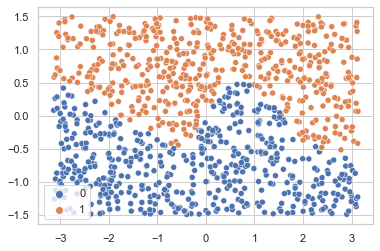

In [14]:
sns.scatterplot(x[:, 0], x[:, 1], hue=th.argmax(mlp(x[:]), 1).cpu().numpy())
plt.show()

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.904


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


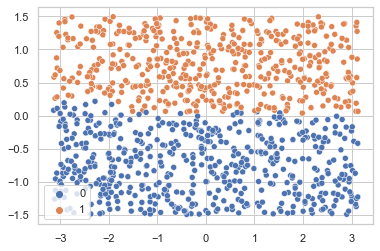

In [16]:
sns.scatterplot(x[:, 0], x[:, 1], hue=clf.predict(x[:, :].numpy()))
plt.show()

Text(0.5, 1.0, 'Synthetic Random Forest Importance')

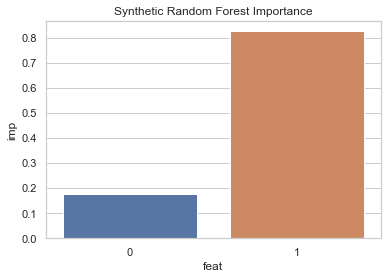

In [17]:
data = pd.DataFrame({"feat": list(range(2)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data).set_title("Synthetic Random Forest Importance")